# 13.1 Basics of Fourier Series and the Fourier Transform

## Fast Fourier transform

Given a function discretized with 2<sup>n</sup> points and represented by a vector **x**, the FFT can be found with [Numpy](https://numpy.org/) function fft.  

In [1]:
import numpy as np
from numpy.fft import fft, fftshift, ifft

To see the practical implications of the FFT, consider the transform of a Gaussian function *f(x) = e<sup>-ax<sup>2</sup></sup>*. 

First, define the computational domain and the number of Fourier modes.

In [2]:
L=20              # define the computational domain [-L/2, L/2]
n=np.power(2,7)   # define the number of Fourier modes 2^n

Create a discretized function over the domain ```[-L/2, L/2]```, ignoring the final point to preserve the illusion of periodicity.   

In [3]:
x = np.linspace(-L/2, L/2, n+1)
x = x[:-1]
u = np.exp(-x*x)          # unlike MATLAB, many Numpy functions default to element-wise operations

Perform a fast Fourier transform on the function, then shift the zero-frequency component of the function to the center of the spectrum.  

In [4]:
ut = fft(u)                       # FFT the function
utshift = fftshift(ut)            # shift FFT

Plot the original function, the unshifted transform, and the shifted transform.  The shift restores the function back to its mathematically correct position.  However, before inverting the transform, it is crucial that the transform is shifted back to the form of the second figure using the function ```numpy.fft.ifftshift```.  In general, unless you need to plot the spectrum, it is better not to deal iwth the ```fftshift``` and ```ifftshift``` functions.  

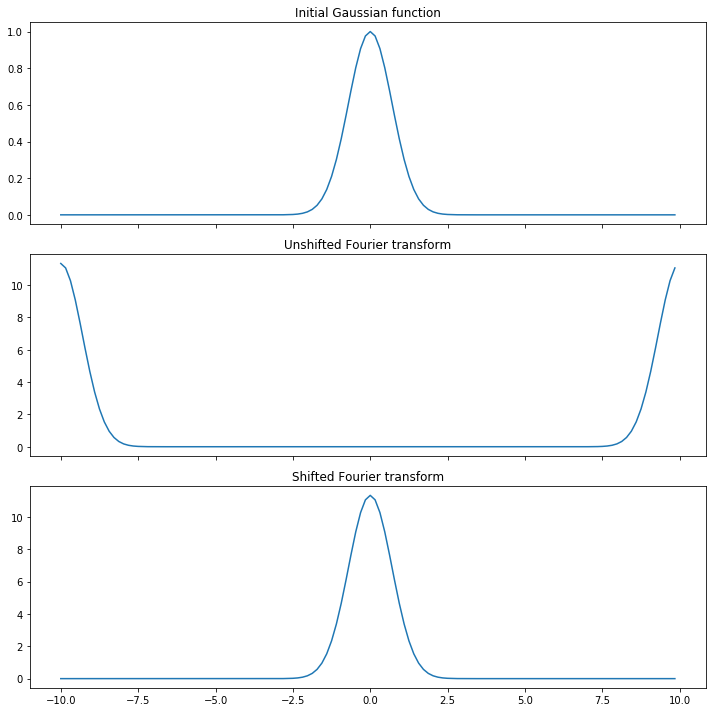

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col')
ax1.plot(x, u)
ax1.set_title('Initial Gaussian function')
ax2.plot(x, abs(ut))
ax2.set_title('Unshifted Fourier transform')
ax3.plot(x, abs(utshift))
ax3.set_title('Shifted Fourier transform')
plt.tight_layout()          # just adds some space between the subplots so the titles are easier to read




## FFT versus finite difference differentiation

The calculation of the derivative of a function using the FFT is performed trivially from the derivative relation formula 13.1.11.  

A comparison can be made between the differentiation accuracy of finite difference formulas and the spectral method using FFTs.  The following code generates the derivative using the FFT method along with the finite difference approximations considered with finite differences.

As an example of how to implement this differentiation formula, consider function **u(x) = sech(x)**.

The hyperbolic secant function has derivative relations   
     **du/dx = -sech(x)tanh(x)**    
     **d<sup>2</sup>u/dx<sup>2</sup> = sech(x) - 2sech<sup>3</sup>(x)**. 

First, calculate the function and its exact derivatives.

In [6]:
# keep the same computational domain (L, x) and number of Fourier modes (n) as used earlier

u = 1/np.cosh(x)             # numpy doesn't have a sech function - use 1/cosh
u1exact = -1 * np.tanh(x) / np.cosh(x)
u2exact = 1/np.cosh(x) - 2/np.power(np.cosh(x), 3)

Use the FFT to calculate derivatives.  Be sure to take the real part after the inverse transform because of numerical rounding that generates a small (on the order of 10<sup>-15</sup>) imaginary part.

In [7]:
ut = fft(u)                  # Fourier transform of sech
# k rescaled to 2pi domain (output from np.arange is exclusive of stop parameter)
k = (2*np.pi/L)*np.concatenate((np.arange(0,n/2), np.arange(-n/2,0)))

ut1 = 1j * k * ut               # first derivative in frequency space
ut2 = -k * k * ut               # second derivative in frequency space
u1 = np.real(ifft(ut1))         # inverse transform the first derivative (back to time space)
u2 = np.real(ifft(ut2))         # inverse transform the second derivative


Now perform a finite difference calculation of the derivatives.

In [8]:
dx = x[1] - x[0]             # dx value needed for finite differences

dbeg = lambda n: -3*u[n] + 4*u[n+1] - u[n+2]  # get appropriate diffs near beginning of the list of values
dend = lambda n: 3*u[n] - 4*u[n-1] + u[n-2]   # get appropriate diffs near end of the list of values

# first derivative finite difference calculation to second-order accuracy
ux = np.concatenate(([dbeg(0)], u[2:] - u[:-2], [dend(-1)]))/(2*dx)
# ... and to fourth-order accuracy
ux2 = np.concatenate(([dbeg(0), dbeg(1)], -u[4:] + 8*u[3:-1] - 8*u[1:-3] + u[:-4], [dend(-2), dend(-1)]))/(12*dx)


Plot the exact derivatives alongside those estimated by FFT and by finite difference calculations to compare the accuracy of the solutions.  Zoom in to see how well each strategy approximates the exact solution.

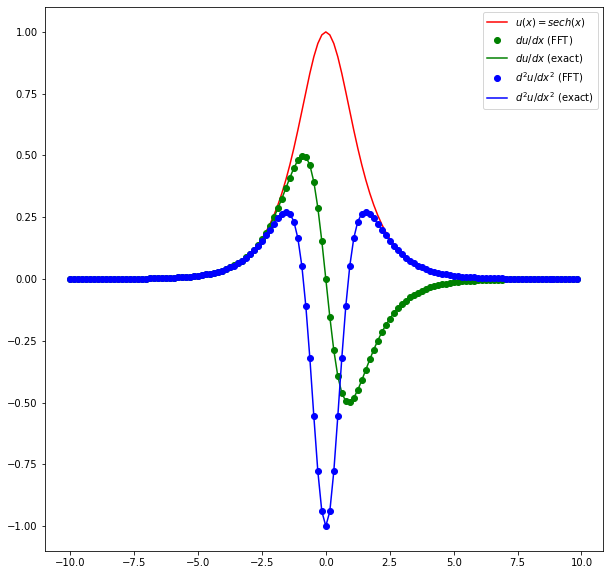

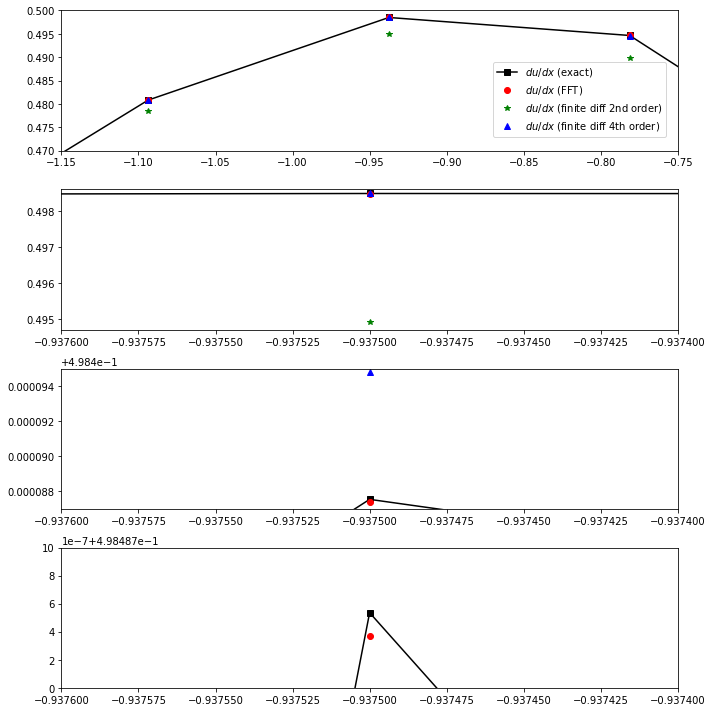

In [9]:
fig, ax = plt.subplots()
l1, l2, l3, l4, l5 = ax.plot(x, u, 'r', x, u1, 'go', x, u1exact, 'g', x, u2, 'bo', x, u2exact, 'b')
ax.legend((l1, l2, l3, l4, l5), ['$u(x) = sech(x)$', '$du/dx$ (FFT)', '$du/dx$ (exact)', '$d^2u/dx^2$ (FFT)', '$d^2u/dx^2$ (exact)'])

fig2, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
e1, f1, d1, d2 = ax1.plot(x, u1exact, 'ks-', x, u1, 'ro', x, ux, 'g*', x, ux2, 'b^')
ax1.set_xlim(-1.15, -0.75)
ax1.set_ylim(0.47, 0.5)
ax1.legend((e1, f1, d1, d2),['$du/dx$ (exact)', '$du/dx$ (FFT)', '$du/dx$ (finite diff 2nd order)', '$du/dx$ (finite diff 4th order)'], loc=(.7,.1))

ax2.plot(x, u1exact, 'ks-', x, u1, 'ro', x, ux, 'g*', x, ux2, 'b^')
ax2.set_xlim(-.9376, -0.9374)
ax2.set_ylim(0.4947, 0.4986)

ax3.plot(x, u1exact, 'ks-', x, u1, 'ro', x, ux, 'g*', x, ux2, 'b^')
ax3.set_xlim(-.9376, -0.9374)
ax3.set_ylim(0.498487, 0.498495)

ax4.plot(x, u1exact, 'ks-', x, u1, 'ro', x, ux, 'g*', x, ux2, 'b^')
ax4.set_xlim(-.9376, -0.9374)
ax4.set_ylim(0.498487, 0.498488)
plt.tight_layout()
